# 6.3 순환 신경망의 고급 사용법

다음 기법들을 적용하겠습니다.
- 순환 드롭아웃(recurrent dropout): 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용합니다.
- 스태킹 순환 층(stacking recurrent layer): 네트워크의 표현 능력(representational power)을 증가시킵니다(그 대신 계산 비용이 많이 듭니다).
- 양방향 순환 층(bidirectional recurrent layer): 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킵니다.

### 6.3.1 기온 예측 문제

#### 코드 6-28 예나의 날시 데이터셋 조사하기

In [3]:
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


#### 코드 6-29 데이터 파싱하기

In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) -1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

#### 코드 6-30 시계열 온도 그래프 그리기

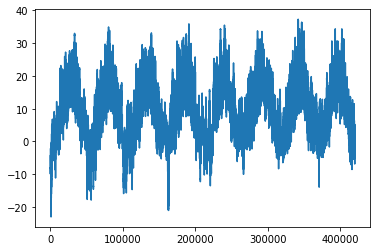

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)

#### 코드 6-31 처음 10일간 온도 그래프 그리기

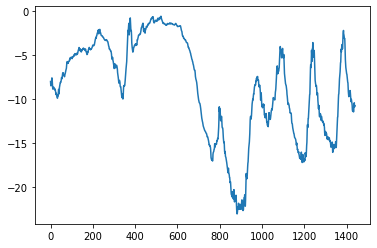

In [5]:
plt.plot(range(1440), temp[:1440])

### 6.3.2 데이터 준비
lookback 타임스텝(하나의 타임스텝은 10분입니다)만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링합니다. 이 데이터를 바탕으로 delay 타임스텝 이후의 온도를 예측할 수 있을까요? 사용할 변수는 다음과 같습니다.
- lookback = 1440: 10일 전 데이터로 돌아갑니다.
- steps = 6: 1시간마다 데이터 포인트 하나를 샘플링합니다.
- delay = 144: 24시간이 지난 데이터가 타깃이 됩니다.

시작 전 두 가지 작업
- 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다.
- float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터(generator)를 만듭니다.

#### 코드 6-32 데이터 정규화하기

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

코드 6-33의 제너레이터 함수에 있는 매개변수
- data: 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
- lookback: 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
- delay: 타깃으로 사용할 미래의 타임스텝
- min_index와 max_index: 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
- shuffle: 샘플을 섞을지, 시간 순서대로 추출할지를 결정합니다.
- batch_size: 배치의 샘플 수
- step: 데이터를 샘플링할 타임스텝 간격, 1시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정

#### 코드 6-33 시계열 데이터와 타깃을 반환하는 제너레이터 함수

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

#### 코드 6-34 훈련, 검증, 테스트 제너레이터 준비하기

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     step=step,
                     batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size  # 전체 검증 세트를 순회학 ㅣ위해 val_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 6.3.3 상식 수준의 기준점
일부 클래스가 월등히 많아 불균형한 분류 문제가 고전적인 예입니다.

이 경우 온도 시계열 데이터는 연속서잉 있고 일자별로 주기성을 가진다고 가정할 수 있습니다(오늘 온도는 내일 온도와 비슷할 가능성이 높습니다). 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후 온도는 지금과 동일하다고 예측하는 것입니다.

```python
np.mean(np.abs(preds - targets))
```

#### 코드 6-35 상식적인 기준 모델의 MAE 계산하기

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


#### 코드 6-36 MAE를 섭씨 단위로 변환하기

In [9]:
celsius_mae = 0.29 * std[1]

### 6.3.4 기본적인 머신 러닝 방법

#### 코드 6-37 완전 연결 모델을 훈련하고 평가하기

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Using TensorFlow backend.
d:\git\jongkwangyun.github.io\aikerasstudy\aikeras\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\git\jongkwangyun.github.io\aikerasstudy\aikeras\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\git\jongkwangyun.github.io\aikerasstudy\aikeras\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:

Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 1.3168 - val_loss: 0.7323
Epoch 2/20
500/500 [==============================] - 10s 19ms/step - loss: 0.3958 - val_loss: 0.3216
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2849 - val_loss: 0.3428
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2638 - val_loss: 0.3047
Epoch 5/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2528 - val_loss: 0.3151
Epoch 6/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2451 - val_loss: 0.3165
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2388 - val_loss: 0.3061
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2322 - val_loss: 0.3916
Epoch 9/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2265 - val_loss: 0.3224
Epoch 10/20
500/500 [==============================] - 10s 20ms/step - loss: 0.223

#### 6-38 결과 그래프 그리기

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

왜 훈련한 모델은 이를 찾지 못하고 성능이 낮을까요? 훈련 과정이 찾는 것은 이런 간단한 모델이 아니기 때문입니다. 문제 해결을 위해 탐색하는 모델의 공간, 즉 가설공간은 우리가 매개변수로 설정한 2개의 층을 가진 네트워크의 모든 가능한 가중치 조합입니다. 이 네트워크는 이미 매우 복잡합니다. 복잡한 모델 공간에서 해결책을 탐색할 때 간단하고 괜찮은 성능을 내는 모델은 찾지 못할 수 있습니다.

### 6.3.5 첫 번재 순환 신경망

GRU(Gated Recurrent Unit) 층은 LSTM과 같은 원리로 작동하지만 조금 더 간결하고, 그래서 계산 비용이 덜 듭니다(LSTM만큼 표현 학습 능력이 높지는 않을 수 있습니다). 계산 비용과 표현 학습 능력 사이의 트레이드오프(trade-off)는 머신 러닝 어디에서나 등장합니다.

#### 코드 6-39 GRU를 사용한 모델을 훈련하고 평가하기

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 188s 377ms/step - loss: 0.3112 - val_loss: 0.2722
Epoch 2/20
500/500 [==============================] - 190s 379ms/step - loss: 0.2830 - val_loss: 0.2676
Epoch 3/20
500/500 [==============================] - 189s 377ms/step - loss: 0.2773 - val_loss: 0.2689
Epoch 4/20
500/500 [==============================] - 190s 380ms/step - loss: 0.2721 - val_loss: 0.2683
Epoch 5/20
500/500 [==============================] - 190s 380ms/step - loss: 0.2685 - val_loss: 0.2675
Epoch 6/20
500/500 [==============================] - 188s 376ms/step - loss: 0.2653 - val_loss: 0.2665
Epoch 7/20
500/500 [==============================] - 189s 378ms/step - loss: 0.2599 - val_loss: 0.2679
Epoch 8/20
500/500 [==============================] - 189s 377ms/step - loss: 0.2549 - val_loss: 0.2683
Epoch 9/20
500/500 [==============================] - 188s 376ms/step - loss: 0.2490 - val_loss: 0.2715
Epoch 10/20
500/500 [==============================] - 189s 377m

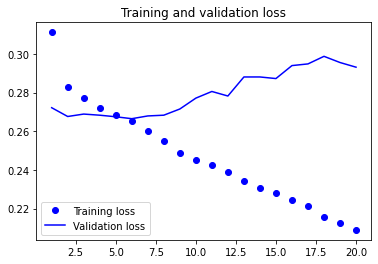

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

상식 수준의 모델을 크게 앞질렀습니다. 이 그림은 시퀀스를 펼쳐서 처리하는 완전 연결 네트워크에 비해서 순환 네트워크가 이런 종류의 작업에 훨씬 뛰어나다는 것과 머신 러닝의 가치를 보여줍니다.

### 6.3.6 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 더 방해되는 것으로 오랫동안 알려졌습니다. 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크 (동일한 유닛의 드롭 패턴)를 모든 타임스텝에 적용해야 합니다. GRU나 LSTM 같은 순환 게이트에 의해 만들어지는 표현을 규제하려면 순환 층 내부 계산에 사용된 활성화 함수에 타임스텝마다 동일한 드롭아웃 마스크를 적용해야 합니다(순환 드롭 아웃 마스크). 모든 타임스텝에 동일한 드롭아웃 마스크를 적용하면 네트워크가 학습 오차를 타임스텝에 걸쳐 적절하게 전파시킬 것입니다. 타임스텝마다 랜덤한 드롭아웃 마스크를 적용하면 오차 신호가 전파되는 것을 방해하고 학습 과정에 해를 끼칩니다.

케라스에 있는 모든 순환 층은 2개의 드롭아웃 매개변수를 가지고 있습니다. dropout은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값입니다. recurrent_dropout은 순환 상태의 드롭아웃 비율을 정합니다.

#### 코드 6-40 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 220s 440ms/step - loss: 0.3341 - val_loss: 0.2744
Epoch 2/40
500/500 [==============================] - 219s 438ms/step - loss: 0.3135 - val_loss: 0.2733
Epoch 3/40
500/500 [==============================] - 216s 432ms/step - loss: 0.3072 - val_loss: 0.2707
Epoch 4/40
500/500 [==============================] - 214s 428ms/step - loss: 0.3033 - val_loss: 0.2689
Epoch 5/40
500/500 [==============================] - 221s 443ms/step - loss: 0.2987 - val_loss: 0.2644
Epoch 6/40
500/500 [==============================] - 221s 443ms/step - loss: 0.2977 - val_loss: 0.2638
Epoch 7/40
500/500 [==============================] - 221s 442ms/step - loss: 0.2944 - val_loss: 0.2647
Epoch 8/40
500/500 [==============================] - 228s 455ms/step - loss: 0.2915 - val_loss: 0.2618
Epoch 9/40
500/500 [==============================] - 226s 452ms/step - loss: 0.2921 - val_loss: 0.2654
Epoch 10/40
500/500 [==============================] - 223s 445m

30번째 에포크까지 과대적합이 일어나지 않았습니다. 평가점수는 안정적이지만 이전보다 더 나아지지는 않았습니다.

### 6.3.7 스태킹 순환 층

과대적합은 더 이상 없지만 성능상 병목이 있는 것 같으므로 네트워크의 용량을 늘려야 합니다. 일반적인 머신 러닝 작업 흐름을 기억하세요. (드롭아웃 등을 사용하여 과대적합을 줄이는 기본 단계를 거쳤다 가정하고) 과대적합이 일어날 때까지 네트워크의 용량을 늘리는 것이 좋습니다. 너무 많이 과대적합되지 않는 한 아직 충분한 용량에 도달한 것이 아닙니다.

네트워크의 용량을 늘리려면 일반적으로 층에 있는 유닛의 수를 늘리거나 층을 더 많이 추가합니다.

케라스에서 순환 층을 차례대로 쌓으려면 모든 중간 층은 마지막 타임스텝 출력만 아니고 전체 시퀀스(3D 텐서)를 출력해야 합니다. return_sequences=True로 지정하면 됩니다.

#### 코드 6-41 드롭아웃으로 규제하고 스태킹한 GRU 모델을 훈련하고 평가하기

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.6,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 459s 919ms/step - loss: 0.3354 - val_loss: 0.2935
Epoch 2/40
500/500 [==============================] - 461s 922ms/step - loss: 0.3170 - val_loss: 0.2744
Epoch 3/40
500/500 [==============================] - 460s 921ms/step - loss: 0.3072 - val_loss: 0.2717
Epoch 4/40
500/500 [==============================] - 453s 906ms/step - loss: 0.3021 - val_loss: 0.2688
Epoch 5/40
500/500 [==============================] - 452s 903ms/step - loss: 0.3001 - val_loss: 0.2698
Epoch 6/40
500/500 [==============================] - 461s 922ms/step - loss: 0.2961 - val_loss: 0.2701
Epoch 7/40
500/500 [==============================] - 459s 918ms/step - loss: 0.2963 - val_loss: 0.2747
Epoch 8/40
500/500 [==============================] - 435s 871ms/step - loss: 0.2927 - val_loss: 0.2686
Epoch 9/40
500/500 [==============================] - 434s 868ms/step - loss: 0.2909 - val_loss: 0.2686
Epoch 10/40
500/500 [==============================] - 435s 871m

KeyboardInterrupt: 

층을 추가하여 성능을 조금 향상시켰지만 크지는 않습니다. 여기서 두 가지 결론을 얻을 수 있습니다.
- 아직 충분히 과대적합을 만들지 못했기 때문에 검증 손실을 향상하기 위해서 층의 크기를 늘릴 수 있습니다. 하지만 적지 않은 계산 비용이 추가됩니다.
- 층을 추가한 만큼 도움이 되지 않았으므로, 여기서는 네트워크의 용량을 늘리는 것이 도움이 되지 않는다고 볼 수 있습니다.

### 6.3.8 양방향 RNN 사용하기

양방향 RNN(bidirectional RNN)은 RNN의 한 변종이고 특정 작업에서 기본 RNN보다 훨씬 좋은 성능을 냅니다. 자연어 처리에서는 맥가이버 칼이라고 할 정도로 즐겨 사용됩니다.

RNN은 특히 순서 또는 시간에 민감합니다. 타임스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꾸어 버립니다. 이는 온도 예측처럼 순서에 의미가 있는 문제에 잘 맞는 이유이기도 합니다.

순서를 뒤집은 GRU는 상식 수준으 기준점보다도 성능이 낮습니다. 기본적인 GRU 층은 먼 과거보다 최근 내용을 잘 기억합니다. 또 최근에 가까운 날씨 데이터 포인트일쑤록 오래된 데이터 포인트보다 예측에 유용합니다(상식 수준의 기준점이 꽤 강력한 이유입니다). 시간 순서대로 처리하는 네트워크가 거꾸로 처리하는 것보다 성능이 높아야만 합니다. 하지만 자연어 처리를 초팜하여 다른 많은 문제에서는 그렇지 않습니다.

#### 코드 6-42 거꾸로 된 시퀀스를 사용한 LSTM을 훈련하고 평가하기

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features개의 단어만 사용합니다.)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)  # 데이터 로드
# 시퀀스를 뒤집습니다.
x_train = [x[::-1] for x in x_train]
y_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다.
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

놀랍게도 이런 텍스트 데이터 셋에는 순서를 뒤집어 처리하는 것이 시간 순서대로 처리하는 것과 거의 동일하게 잘 작동합니다. 이는 언어를 이해하는 데 단어의 순서가 중요하지만 결정적이지 않다는 가정을 뒷받침합니다.

#### 코드 6-43 양방향 LSTM을 훈련하고 평가하기

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

여기서 얻은 검증 정확도는 88% 정도로 이전 절에서 사용했던 일반 LSTM보다 성능이 조금 더 높습니다. 규제를 조금 추가한다면 양방향 순환 층을 사용하는 것이 이 작업에 더 적합해 보입니다.

이제 동일한 방식을 온도 예측 문제에 적용해 보죠.

#### 코드 6-44 양방향 GRU 훈련하기

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

이 네트워크는 일반 GRU 층과 비슷한 성능을 냅니다. 모든 예측 성능은 시간 순서대로 처리하는 네트워크의 절반에서 옵니다. 시간 반대 순서로 처리하는 절반은 이런 작업에 성능이 매우 좋지 않기 때문입니다.

### 6.3.9 더 나아가서
온도 예측 문제의 성능을 향상하기 위해 시도해 볼 수 있는 것들이 많이 있습니다.
- 스태킹한 각 순환 층의 유닛 수를 조정합니다. 지금 설정은 대부분 임의로 한 것이라 최적화가 덜 되었을 것입니다.
- RMSprop 옵티마이저가 사용한 학습률을 조정합니다.
- GRU 대신 LSTM 층을 사용합니다.
- 순환 층 위에 용량이 큰 완전 연결된 회귀 층을 사용합니다. 즉 유닛 수가 많은 Dense 층 한 개 또는 여러 개의 DEnse 층을 스태킹합니다.
- 최종적으로 (검증 MAE 기준으로 보았을 때) 최선의 모델을 테스트 세트에서 확인해야 합니다. 이를 잊으면 검증 세트에 과대적합된 네트워크 구조를 만들게 될 것입니다.

늘 그렇듯이 딥러닝은 과학보다는 예술에 가깝습니다.

### 6.3.10 정리
이 절에서 배운 것
- 4장에서 처음 배웠던 것처럼 새로운 문제를 해결할 때는 선택한 지표에서 상식 수준의 기준점을 설정하는 것이 좋습니다.
- 계산 비용을 추가할지 판단하기 위해서 비용이 비싼 모델 전에 간단한 모델을 시도합니다.
- 시간 순서가 중요한 데이터가 있다면 순환 층이 적합합니다.
- 순환 네트워크에 드롭아웃을 사용하려면 타임스텝 동안 일정한 드롭아웃 마스크와 순환 드롭아웃 마스크를 사용해야 합니다.
- 스태킹 RNN은 단일 RNN 층보다 더 강력한 표현 능력을 제공합니다. 하지만 계산 비용이 많이 들기 때문에 항상 시도할 가치가 있지는 않습니다. (기계 번역 같은) 복잡한 문제에서 확실히 도움이 되지만 작고 간단한 문제에서는 항상 그렇지 않습니다.
- 양쪽 방향으로 시퀀스를 바라보는 양방향 RNN은 자연어 처리 문제에 유용합니다. 하지만 최근 정보가 오래된 것보다 훨씬 의미 있는 시퀀스 데이터에는 잘 작동하지 않습니다.